# Using TensorFlow to create and train neural networks

To work with TensorFlow, we first need to install it. Uncomment the code below, if you haven't already done so (note that we use `pydot` and `graphviz` for visualizing the hidden layers of a neural network - but they are not necessary to run neural networks in TensorFlow).

Note that parts 4 and 6 of the notebook build on a GitHub repository by [Aurélien Géron](https://github.com/ageron/handson-ml2).

In [4]:
# !pip install tensorflow
# !pip install pydot
# !pip install graphviz

Once we have installed all packages, let's do the obligatory imports:

In [5]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Getting started

## 1.1 Creating tensors

There are two types of "variables" in TensorFlow that you might work with. Actual variables, `tf.Variables`, which can be changed once they have been set, as well as constants , `tf.constant`, which cannot be changed anymore. Let's create a random array of data `X`, as well as parameter matrices `W` and `b`. Can you see why we would use `tf.constant` for `X` and `tf.Variable` for `W` and `b`?

In [6]:
X = tf.constant(np.random.randn(100,5), name = "X")
X.shape

TensorShape([100, 5])

Note that the "tensor" we create has exactly the dimension of the numpy array we use to initialize it. TensorFlow allows you to use `numpy` data quite seamlessly.

In [7]:
W = tf.Variable(np.random.randn(5,3), name = "W")
W.shape

TensorShape([5, 3])

In [8]:
b = tf.Variable(np.random.randn(1,3), name = "b")
b.shape

TensorShape([1, 3])

## 1.2 Basic operations on tensors

Let's now perform some basic operations on tensors. These work essentially the same way as in `numpy` (e.g., the typical rules of matrix-multiplication apply when we use `tf.matmul`), just that we have to learn a few different key-words:

In [9]:
z = tf.add(tf.matmul(X,W),b)
z.shape

TensorShape([100, 3])

TensorFlow has all the standard activation functions in-built, for example, the logistic sigmoid one:

In [10]:
a = tf.keras.activations.sigmoid(z)
a.shape

TensorShape([100, 3])

## 1.3 Type-casting

One aspect of TensorFlow you might know from other programming languages, but which is usually taken care of for you in base Python, is that types are not automatically "cast". What that means is that we cannot run operations such as multiplying an integer and a float tensor. We cannot even multiply a `float32` tensor with a `float64` tensor! You can find the datatype of any tensor by printing it out, or by specifically looking at `tensor.dtype`:

In [11]:
b

<tf.Variable 'b:0' shape=(1, 3) dtype=float64, numpy=array([[-1.67281316, -1.16828438, -0.74939484]])>

In [12]:
b.dtype

tf.float64

We will now (explicitly) convert `b` from a `tf.float64` data-type (a float with 64 bits of precision), to a `tf.float32` data-type (a float with 32 bits of precision):

In [13]:
b = tf.cast(b,tf.float32)

Note that `X` and `W` are still of type `tf.float64` (the default). Let's try the following:

In [14]:
tf.add(tf.matmul(X,W),b)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:AddV2]

This didn't work! Let's re-cast `b` into a `tf.float64`

In [17]:
b = tf.cast(b, tf.float64)

In [18]:
b.dtype

tf.float64

In [19]:
tf.add(tf.matmul(X,W),b)

<tf.Tensor: shape=(100, 3), dtype=float64, numpy=
array([[-7.64027074e-01, -3.56661074e+00,  2.40966375e-01],
       [-4.74529061e+00,  2.15831352e+00, -1.21406336e-01],
       [-8.84677449e-01, -3.99877121e+00, -2.84347014e+00],
       [-4.37057335e+00,  2.96729305e+00, -8.21134852e-01],
       [-1.76254474e+00, -3.39891227e+00,  1.85219313e-01],
       [-2.15352360e+00, -3.76568586e-01,  2.87186019e-01],
       [ 3.51860022e+00, -5.58836538e+00, -6.73002528e-01],
       [-4.97550056e+00,  1.48877444e+00,  5.75002761e-01],
       [-4.60920743e+00,  2.86483997e+00, -5.38365374e-01],
       [ 2.85646875e+00, -6.10539607e+00,  6.88009419e-02],
       [ 2.89943181e+00, -6.79681006e+00, -2.44536059e+00],
       [-1.68453957e+00,  8.76036447e-01, -3.19867060e-02],
       [-1.25648307e+00, -1.86885590e+00, -2.19831958e+00],
       [-2.64735149e+00,  1.42629143e+00, -5.68940273e-02],
       [-2.06260785e+00, -3.06566923e+00, -2.70381571e+00],
       [-1.35106464e+00,  1.21339622e+00,  1.32126

Now it works again!

## 1.4 Some other useful operations

Let's look at `tf.one_hot` and `tf.reshape`, two operations you come across a lot when handling data in TensorFlow. Can you see what they do?

In [23]:
y = tf.constant(3)
y_one_hot = tf.one_hot(y,4,axis=0)
y_one_hot

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>

In [28]:
y = [2]
y_one_hot = tf.one_hot(y,4,axis=0)
y_one_hot

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [29]:
tf.reshape(y_one_hot,(4,))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>

# 2. Creating a simple neural network with the Sequential API

We will recreate what we did in the last lecture: a logistic regression model that allows us to differentiate between sign-language digits 0 and 1. But this time, we will be using TensorFlow's Sequential API to build a (single-neuron) neural network. The data-handling is the same as last week:

In [30]:
X = np.load('digits_X.npy')
y = np.load('digits_y.npy')
X = np.concatenate((X[204:409], X[822:1028] ), axis=0)
z = np.zeros(409-204)
o = np.ones(1028-822)
y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=172)

In [33]:
X[204].shape

(64, 64)

## 2.1 Building the model

Let's create the model. Notice that we haven't flattened the observations (recall that each value of `X` is a matrix!). The beauty about TensorFlow is that we can simply add in a `Flatten` layer, to do this for us. Hence, we have two layers in our model: the `Flatten` layer (not an actual neural network layer), and a standard `Dense` layer, with one neuron/unit (the one that performs the logistic regression).

For our `Dense` layer with one neuron, we also need to specify the activation function. Of course, for a logistic regression, we use the logistic sigmoid function, simply `'sigmoid'` in TensorFlow.

In [34]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Now that we have created our model, we can take a look at its layers:

In [35]:
model.layers

The `model.summary()` is a bit more informative:

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 1)                 4097      
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


The `Flatten` layer flattens each input from a (64,64)-matrix to a (4096,)-vector. However, it says (None, 4096) for the output shape. Can you guess why?

Also, can you guess what the 4097 parameters are?

In order to use our model, we also have to `compile` it. This is the step where we decide on
- the optimization algorithm (we will use `'sgd'`, or "stochastic gradient descent", which is very similar to the gradient descent method we've seen before - we will deal with the exact difference later),
- the loss function (we will use `'binary_crossentropy'`, as before),
- the metrics to keep track of as the model is being trained, in the form of a list (we will only keep track of `'accuracy'` for now).

In [37]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

That's it! When we compile the model, it automatically creates the forward propagation and back-propagation steps for us, based on the layers and cost function we define!

## 2.2 Training the model

We will now train the model, using the training data. We will run it for 100 "epochs", that is iterations of our optimization algorithm:

In [38]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
11/11 [==============================] - 0s 700us/step - loss: 2.2175 - accuracy: 0.5072
Epoch 2/100
11/11 [==============================] - 0s 600us/step - loss: 2.5816 - accuracy: 0.4441
Epoch 3/100
11/11 [==============================] - 0s 700us/step - loss: 1.7530 - accuracy: 0.5272
Epoch 4/100
11/11 [==============================] - 0s 700us/step - loss: 1.5823 - accuracy: 0.5817
Epoch 5/100
11/11 [==============================] - 0s 600us/step - loss: 1.9867 - accuracy: 0.5014
Epoch 6/100
11/11 [==============================] - 0s 800us/step - loss: 1.6990 - accuracy: 0.4928
Epoch 7/100
11/11 [==============================] - 0s 700us/step - loss: 1.0771 - accuracy: 0.6132
Epoch 8/100
11/11 [==============================] - 0s 800us/step - loss: 1.2184 - accuracy: 0.5817
Epoch 9/100
11/11 [==============================] - 0s 1ms/step - loss: 1.0319 - accuracy: 0.6390
Epoch 10/100
11/11 [==============================] - 0s 700us/step - loss: 0.9818 - accuracy

Let's restart the process (we will use `clear_session` to properly clear out TensorFlow's cache, and then define random seeds for `numpy` and `tf` (this is good practice to do right after the clear out). Other than that, we will only make three small changes:
- We add validation data to the training process (we will here simply use the test data - not best practice, but this is just for showing you how the TensorFlow training can directly consider a validation data set)
- Instead of using the default `'sgd'` optimizer, we manually specify the learning rate, using the `tf.keras.optimizers.SGD` object
- We also save the output of `model.fit`, as this will be interesting for drawing graphs

In [39]:
tf.keras.backend.clear_session()
np.random.seed(672)
tf.random.set_seed(323)

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
log = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1260 - accuracy: 0.5129 - val_loss: 2.7152 - val_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 2.3290 - accuracy: 0.4785 - val_loss: 2.2426 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 1.7675 - accuracy: 0.5387 - val_loss: 1.8040 - val_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 1.6974 - accuracy: 0.5215 - val_loss: 1.4428 - val_accuracy: 0.5000
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 1.7869 - accuracy: 0.4814 - val_loss: 2.4742 - val_accuracy: 0.5000
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 1.7324 - accuracy: 0.5043 - val_loss: 0.9446 - val_accuracy: 0.5645
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 1.2033 - accuracy: 0.5301 - val_loss: 1.2108 - val_accuracy: 0.5161
Epoch 8/100


We can now use the log to see how the training went. The `log.history` is a dictionary that will capture, for each epoch, all the metrics we defined for our model (`['accuracy']` in our case), as well as the cost/loss, for both the training and the "validation" dataset. The keywords to use in the dictionary are simply the words you can find in the log above.

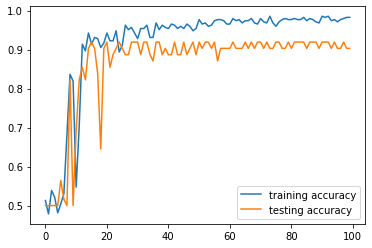

In [41]:
plt.plot(log.history['accuracy'],label = "training accuracy")
plt.plot(log.history['val_accuracy'], label = "testing accuracy")
plt.legend()
plt.show()

We can also look at the parameters and how they have been adjusted when the model was trained. Remember that `model.layers` gives us all the layers of our model:

In [42]:
model.layers

We can access these layers with standard Pythonic indexing. E.g., the output layer in our case is layer 1:

In [43]:
output_layer = model.layers[1]

Let's now take a look at both the weights and the bias after training. Before you run the cell, ask yourself: how many weights and biases do you expect there to be?

In [44]:
weights, bias = output_layer.get_weights()
print(weights)
print('----')
print(weights.shape)
print('----')
print(bias)

[[-0.04198132]
 [ 0.01707025]
 [-0.00310804]
 ...
 [-0.00260571]
 [ 0.00139164]
 [-0.0188955 ]]
----
(4096, 1)
----
[-0.00514784]


## 2.3 Making predictions

To make predictions, we simply input the data we want to make predictions on into the model we have trained. `.numpy()` just helps with formatting

In [45]:
predictions = model(X_test).numpy()

As before, our predictions are values between 0 and 1. let's get actual binary classification predictions:

In [46]:
print(predictions > 0.5)

[[ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]]


# 3. Creating a deeper neural network with TensorFlow

We will now create a deeper neural network with TensorFlow's Sequential API (the same one we were just using now). Before we do so, let's properly clear out the cache and set some new random seeds:

In [47]:
tf.keras.backend.clear_session()
np.random.seed(745)
tf.random.set_seed(498)

We can now create the model. We can either create it in one go:
```
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(3, kernel_initializer = 'uniform', activation='relu')
  tf.keras.layers.Dense(3, kernel_initializer = 'uniform', activation='relu')
  tf.keras.layers.Dense(1, kernel_initializer = 'uniform', activation='sigmoid')
])
```
or we can add layers one-by-one:

In [48]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(64,64)))
model.add(tf.keras.layers.Dense(3, kernel_initializer = 'uniform', activation="relu"))
model.add(tf.keras.layers.Dense(3, kernel_initializer = 'uniform', activation="relu"))
model.add(tf.keras.layers.Dense(1, kernel_initializer = 'uniform', activation="sigmoid"))

A few things to note: We are using the `Flatten` layer again, to convert our input-matrices into input-vectors. We then add a number of hidden layers and an output layer. Can you see how many hidden layers there are and how many neurons are at each?

As in the tutorial, we use `'relu'` units at the hidden layer and a `sigmoid` unit at the output layer. We also add in a `kernel_initializer`: we are specifying how the parameters should be initialized (uniformly random). In this particular case, the default initialization is likely not to work, but feel free to try it out as well.

In general, if you are unsure about any of the inputs to the TensorFlow functions, make sure to check the [amazing documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).

As before, we can print out a summary of the `model`:

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 3)                 12291     
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 12,307
Trainable params: 12,307
Non-trainable params: 0
_________________________________________________________________


Do the shapes make sense to you?

Can you account for the number of parameters?

We can also visualize the layers of our model:

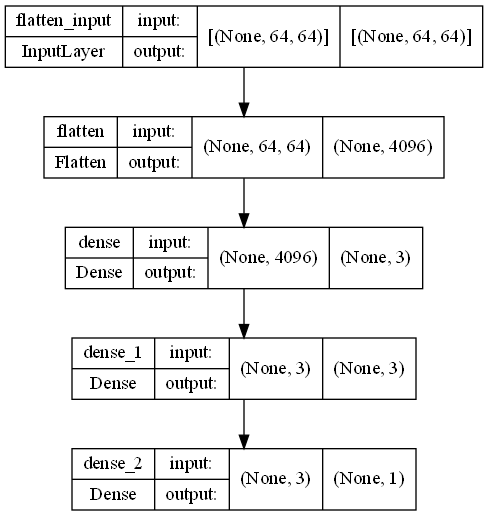

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

And as before, we can take a look at it's parameters (note that we haven't trained the model yet, so these are the randomly generated weights and biases):

In [51]:
hidden_layer = model.layers[1]

In [52]:
weights, bias = hidden_layer.get_weights()
print(weights)
print('----')
print(weights.shape)
print('----')
print(bias)
print('----')
print(bias.shape)

[[-0.03442458  0.02409644 -0.00317553]
 [ 0.03405425  0.04183463  0.02363134]
 [-0.01410528  0.00398878 -0.02459477]
 ...
 [-0.04881406  0.0035608   0.010118  ]
 [ 0.00857428 -0.01074004 -0.02533538]
 [ 0.01472672 -0.00028157 -0.03800116]]
----
(4096, 3)
----
[0. 0. 0.]
----
(3,)


Finally, before training the model, we need to compile it again. As before, we use `'sgd'` as an optimization algorithm, and `'binary_crossentropy'` as our loss (or cost) function:

In [53]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

## 3.1 Training the model

Let's now run the model for 100 epochs, similar to what we did before:

In [54]:
log = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.4814 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4269 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4585 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4642 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4699 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4756 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/100


Did you see anything happening? Why do you think this is the case? What do you think happens if we really crank up the iterations (say, to a few thousand)?



We will try again, this time with a different optimization-algorithm, `'adam'` (again, don't worry too much about what exactly `'adam'` does, we will see this later in class). For this, we have to recompile the model. Keep in mind, however, that the weights and biases will already be at exactly the level they have been trained to in the previous training attempt:

In [55]:
model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

Let's try again:

In [56]:
log = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6930 - accuracy: 0.5014 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5014 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5014 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5014 - val_loss: 0.6879 - val_accuracy: 0.5000
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5014 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5014 - val_loss: 0.6786 - val_accuracy: 0.5000
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5244 - val_loss: 0.6712 - val_accuracy: 0.5000
Epoch 8/100


Looks much better, right? As before, we can display the training process:

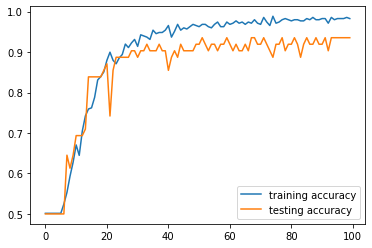

In [57]:
plt.plot(log.history['accuracy'],label = "training accuracy")
plt.plot(log.history['val_accuracy'], label = "testing accuracy")
plt.legend()
plt.show()

# 4. Can you build on what you have seen? Creating a neural network for regression

We will now use a neural network for regression instead of classification. In particular, we will load a standard scikit-learn dataset that contains key characteristics of some houses in california, as well as their values (in $100,000). We will then try to predict the houses' values.

In [58]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [59]:
housing = fetch_california_housing()

The housing data comes as a dictionary: We can find the features of the data as follows:

In [60]:
housing['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

The actual observations (or, more precisely, the feature matrix `X`) comes with the key `'data'`:

In [61]:
housing['data'].shape

(20640, 8)

The labels come with the key `'target'`:

In [62]:
housing['target'].shape

(20640,)

As always, we start by splitting the data. We will use a training, a validation, and a testing set:

In [63]:
X_train, X_other, y_train, y_other = train_test_split(housing['data'], housing['target'], train_size=0.7, random_state=461)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(14447, 8)
(3097, 8)
(3096, 8)


Next, we normalize the X-data. Keep in mind to not use the validation or test data in defining how the scaling process works (otherwise, you can leak information about this data into your training process). You can, however, use the same scaler on validation and test data, rather than defining your own scalers here - this will usually work better than normalizing all data independently:

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## 4.1 Building a neural network

Let's clear our TensorFlow session and set new seeds. Even if not strictly necessary, this is good practice.

In [65]:
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

Now it's your turn! Build a neural network with three `Dense` layers: two hidden layers with `'relu'` activation, and one final output layer. The hidden layers should have 10 neurons each. For the first hidden layer, you have to specify the correct `input_shape`. Recall that this corresponds to the columns in our X-data. But make sure that `input_shape` is a list or a tuple, not just a single value, otherwise there will be an error.

For the output layer, consider whether we need any activation function at all. Remember that a linear regression is just a weighted sum of inputs plus a bias (sounds familiar?)

Save your model as `model`.

If you are stuck, first take a look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) of the `Dense` layers.

In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

As always, it helps to visualize your model with the `summary()` function:

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


As before, try to answer the following questions:
- Do the shapes make sense to you?
- Can you account for the number of parameters?

Now, compile your model. We are doing regression, so it is quite natural to use `'mean_squared_error'` as the loss function.

Moreover, we will us `'sgd'` as before. However, instead of specifying `optimizer = 'sgd'`, we will make a custom optimizer function, which allows us to choose our own learning rate. In particular, you should use
```
optimizer=tf.keras.optimizers.SGD(learning_rate=0.03))
```

Finally, since we are not doing classification, there is no accuracy to keep track of, so simply leave out the `metrics` argument.

In [68]:
model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.03))

Train your model for 30 epochs, also keeping track of the `validation_data`. Save the output as `log`.

In [69]:
log = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
452/452 [==============================] - 0s 721us/step - loss: 0.6704 - val_loss: 0.4247
Epoch 2/30
452/452 [==============================] - 0s 621us/step - loss: 0.4275 - val_loss: 0.4333
Epoch 3/30
452/452 [==============================] - 0s 614us/step - loss: 0.4005 - val_loss: 0.4046
Epoch 4/30
452/452 [==============================] - 0s 603us/step - loss: 0.3867 - val_loss: 0.3848
Epoch 5/30
452/452 [==============================] - 0s 601us/step - loss: 0.3736 - val_loss: 0.4529
Epoch 6/30
452/452 [==============================] - 0s 610us/step - loss: 0.3671 - val_loss: 0.3698
Epoch 7/30
452/452 [==============================] - 0s 599us/step - loss: 0.3586 - val_loss: 0.3675
Epoch 8/30
452/452 [==============================] - 0s 599us/step - loss: 0.3526 - val_loss: 0.3632
Epoch 9/30
452/452 [==============================] - 0s 594us/step - loss: 0.3475 - val_loss: 0.3605
Epoch 10/30
452/452 [==============================] - 0s 590us/step - loss: 0.339

Use the code below to display the loss on both the training and the validation set:

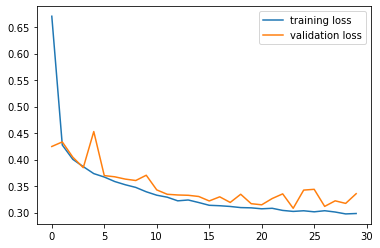

In [70]:
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

We can evaluate the model on the test set directly, using `model.evaluate(X_test,y_test)`. Try it out:

In [71]:
model.evaluate(X_test, y_test)

97/97 [==============================] - 0s 448us/step - loss: 0.3595


0.3594611585140228

Finally, we can take a look at some examples and see how well we are doing on those. Run the code below, and feel free to adjust the examples.

In [72]:
X_new = X_test[:5]
y_predict = model.predict(X_new)
y_predict = y_predict.reshape(-1,)
y_predict = [round(y,3) for y in y_predict]

In [73]:
print("Predicted values: " + str(y_predict))
print("True values: " + str(y_test[:5]))

Predicted values: [1.24, 3.224, 0.721, 1.544, 1.528]
True values: [1.135 4.292 0.699 1.222 1.75 ]


Can you do better? Try tweaking the learning rate, the number of layers, and the neurons per layer to see if your validation loss improves. Once you have decided on your final model, evaluate it on the test set and note down your loss there.

## 4.2 Visualization with TensorBoard

We will now see how we can use TensorBoard to get more in-depth visualizations of our training process and our model. Let's start by cleaning up and making some additional imports:

In [74]:
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [75]:
import os
import datetime

We can now load TensorBoard into the Jupyter Notebook and specify where the relevant logs should be kept that are needed to visualize the training process:

In [76]:
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

We build the same baseline model as before:

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.03))

We train our model as before, but we add a so-called `callback`. There are many types of callbacks, and you will discover some of them later, but TensorBoard brings its very own one.

Note that we are defining a list of `callbacks`, but for now, we keep it at a single one:

In [78]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/30
452/452 [==============================] - 1s 741us/step - loss: 0.6704 - val_loss: 0.4247
Epoch 2/30
452/452 [==============================] - 0s 599us/step - loss: 0.4275 - val_loss: 0.4333
Epoch 3/30
452/452 [==============================] - 0s 623us/step - loss: 0.4005 - val_loss: 0.4046
Epoch 4/30
452/452 [==============================] - 0s 628us/step - loss: 0.3867 - val_loss: 0.3848
Epoch 5/30
452/452 [==============================] - 0s 654us/step - loss: 0.3736 - val_loss: 0.4529
Epoch 6/30
452/452 [==============================] - 0s 645us/step - loss: 0.3671 - val_loss: 0.3698
Epoch 7/30
452/452 [==============================] - 0s 605us/step - loss: 0.3586 - val_loss: 0.3675
Epoch 8/30
452/452 [==============================] - 0s 607us/step - loss: 0.3526 - val_loss: 0.3632
Epoch 9/30
452/452 [==============================] - 0s 605us/step - loss: 0.3475 - val_loss: 0.3605
Epoch 10/30
452/452 [==============================] - 0s 617us/step - loss: 0.339

In the training process, nothing has chaged, except that you will now find a log in your working directory. We can call upon that log to display the TensorBoard as follows (if you get an error, keep reading below)

In [79]:
%tensorboard --logdir logs

You may run into an issue here because of a conflict between TensorBoard and the environment you are using. If this is the case, you need to specify exactly where TensorBoard can be found. It should be within your environment's folder, under "bin". You can find an example below. Uncomment the next lines and adjust your path accordingly:

In [80]:
# os.environ['TENSORBOARD_BINARY'] = '/Users/philippe/anaconda3/envs/adl_env/bin/tensorboard'
# %tensorboard --logdir logs

Enjoy exploring the TensorBoard. We will see later that we can still add a lot more functionality to it. It is particularly nice for comparing different models.

## 4.3 Saving and loading models

Sometimes, we need to save our models, instead of training them from scratch (training deep neural networks can take quite some time!) TensorFlow enables this quite easily, for example with the following code. Once you have saved the model, check your working directory and you will find it there (as an "h5" file).

In [81]:
model.save("my_tf_regression_model.h5")

We can now call up the (trained) model, just as easily:

In [82]:
saved_model = tf.keras.models.load_model("my_tf_regression_model.h5")

Verify that this is the trained model by running the predictions on it. You should get the same result as with the original model:

In [83]:
X_new = X_test[:5]
y_predict = saved_model.predict(X_new)
y_predict = y_predict.reshape(-1,)
y_predict = [round(y,3) for y in y_predict]
print("Predicted values: " + str(y_predict))
print("True values: " + str(y_test[:5]))

Predicted values: [1.24, 3.224, 0.721, 1.544, 1.528]
True values: [1.135 4.292 0.699 1.222 1.75 ]


Sometimes, you might want to save only the parameters of the model, not the entire model. Again, TensorFlow allows us to save and load the parameters quite easily:

In [84]:
model.save_weights("my_tf_regression_weights.ckpt")

In [85]:
model.load_weights("my_tf_regression_weights.ckpt")

## 4.4 Callbacks

When using TensorBoard, we already saw a Callback in action. We will now get back to those, more generally. The idea is, that you might want to "do stuff" while training your model (for example, saving your current progress, in case your computer crashes). We start by defining our model:

In [86]:
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [87]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.03))

Let's now create a `ModelCheckpoint`, which is a call-back that saves your model in each iteration (epoch) of training. That is, whatever you might do later on with your model, you can always get back to the trained version.

In your checkpoint, you will need to specify how the model should be saved as. Moreover, if you are using `validation_data` when training your model, you can also specify `save_best_only=True`. This means, that the callback looks at your validation_loss, and only saves the model at its current state if the validation loss is better (i.e. lower) than the one in the previous saved version. Quite useful, right?

In [88]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_best_tf_regression_model.h5", save_best_only=True)

Once we have generated the callback, we add it to our callback list in training, as we did for TensorBoard. Nothing else changes:

In [89]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

Epoch 1/30
452/452 [==============================] - 1s 796us/step - loss: 0.6704 - val_loss: 0.4247
Epoch 2/30
452/452 [==============================] - 0s 630us/step - loss: 0.4275 - val_loss: 0.4333
Epoch 3/30
452/452 [==============================] - 0s 654us/step - loss: 0.4005 - val_loss: 0.4046
Epoch 4/30
452/452 [==============================] - 0s 662us/step - loss: 0.3867 - val_loss: 0.3848
Epoch 5/30
452/452 [==============================] - 0s 641us/step - loss: 0.3736 - val_loss: 0.4529
Epoch 6/30
452/452 [==============================] - 0s 692us/step - loss: 0.3671 - val_loss: 0.3698
Epoch 7/30
452/452 [==============================] - 0s 637us/step - loss: 0.3586 - val_loss: 0.3675
Epoch 8/30
452/452 [==============================] - 0s 641us/step - loss: 0.3526 - val_loss: 0.3632
Epoch 9/30
452/452 [==============================] - 0s 639us/step - loss: 0.3475 - val_loss: 0.3605
Epoch 10/30
452/452 [==============================] - 0s 628us/step - loss: 0.339

You can now run `tf.keras.models.load_model("my_best_tf_regression_model.h5")` to call up the version of your model that had the best validation loss.

Another useful callback to try out (this is left to you) is the `EarlyStopping` callback, which stops the training process if the validation loss isn't improving anymore. You can call it as follows:
```
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
```

Here, `patience` defines the number of epochs which the callback waits for improvements before stopping the training. `restore_best_weights=True` means that, once training is stopped, you get the version of the model that led to the best validation loss, not the final version of the model.

# 5. Multi-class classification with softmax

We will now see how to use a softmax activation function to classify observations into multiple classes. As always, we start by cleaning up:

In [90]:
tf.keras.backend.clear_session()
np.random.seed(583)
tf.random.set_seed(21)

For this example, we will use the full digits dataset (recall that we had images of ten sign-language digits, with the corresponding one-hot-encoded labels). We will split the dataset into training, test and validation sets:

In [91]:
X = np.load('digits_X.npy')
y = np.load('digits_y.npy')
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=342)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=152)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(1649, 64, 64)
(1649, 10)
(207, 64, 64)
(207, 10)
(206, 64, 64)
(206, 10)


We train a simple feed-forward network, with two hidden layers, plus the softmax layer. Remember also that we need to flatten the image-matrics:

In [92]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64)),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

As always, it is useful to take a look at our model and try to spot any possible issues:

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 300)               1229100   
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 1,270,310
Trainable params: 1,270,310
Non-trainable params: 0
_________________________________________________________________


We can then compile the model. For multiple categories, we will usually use the `categorical_crossentropy` loss (with some exceptions, one of which you will come across in this week's homework). We also use the `'adam'` optimization algorithm (with our self-defined learning rate), which we talk about in class next week. Otherwise, let's again keep track of `'accuracy'`:

In [94]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

We can now run the model, we will use 200 epochs for now:

In [95]:
log = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
52/52 [==============================] - 1s 6ms/step - loss: 2.4375 - accuracy: 0.1255 - val_loss: 2.3256 - val_accuracy: 0.1159
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 2.2631 - accuracy: 0.1631 - val_loss: 2.2127 - val_accuracy: 0.2126
Epoch 3/100
52/52 [==============================] - 0s 5ms/step - loss: 2.1182 - accuracy: 0.2462 - val_loss: 1.9482 - val_accuracy: 0.3527
Epoch 4/100
52/52 [==============================] - 0s 5ms/step - loss: 1.8722 - accuracy: 0.3354 - val_loss: 1.9026 - val_accuracy: 0.2995
Epoch 5/100
52/52 [==============================] - 0s 5ms/step - loss: 1.6693 - accuracy: 0.3814 - val_loss: 1.5524 - val_accuracy: 0.4010
Epoch 6/100
52/52 [==============================] - 0s 5ms/step - loss: 1.4877 - accuracy: 0.4603 - val_loss: 1.4556 - val_accuracy: 0.4976
Epoch 7/100
52/52 [==============================] - 0s 5ms/step - loss: 1.4758 - accuracy: 0.4536 - val_loss: 1.3541 - val_accuracy: 0.5362
Epoch 8/100
5

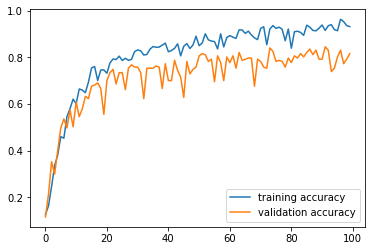

In [96]:
plt.plot(log.history['accuracy'],label = "training accuracy")
plt.plot(log.history['val_accuracy'], label = "validation accuracy")
plt.legend()
plt.show()

It seems we are experiencing some over-fitting. This is an issue that we will turn to next week!

Finally, let's evaluate the model on the test data:

In [97]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.7290 - accuracy: 0.8010


[0.7290115356445312, 0.8009708523750305]

# 6. More multiclass-classification (homework)

For this part, we will train a neural network on a dataset of fashion-products that is labeled with the categories of each product. The data is loaded directly from TensorFlow (which has quite the broad collection of datasets):

In [98]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_other, y_other), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [99]:
print(X_other.shape)
print(y_other.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


The X's are matrices (with 28x28 pixels), while the y's are numbers.

We divide the values of X by 255 (essentially standardizing the pixel-values to 0-1) and also split apart a validation set (of the same size as the test set):

In [100]:
X_other = X_other / 255.
X_test = X_test / 255.
X_train, X_valid, y_train, y_valid = train_test_split(X_other, y_other, train_size = 50000, random_state=152)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(50000, 28, 28)
(50000,)
(10000, 28, 28)
(10000,)


Let's plot two examples:

(-0.5, 27.5, 27.5, -0.5)

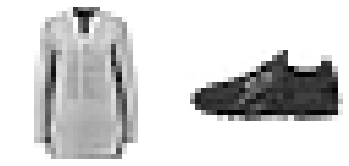

In [101]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[0],cmap="binary")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_train[500],cmap="binary")
plt.axis('off')

As well as the corresponding labels:

In [102]:
print(y_train[0])
print(y_train[500])

6
7


That's a bit hard to interpret. Luckily, we have the right names for each label available:

In [103]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

We can now take another look at what the pictures above represent:

In [104]:
print(class_names[y_train[0]])
print(class_names[y_train[500]])

Shirt
Sneaker


## 6.1 Training the model

Let's start with some housekeeping:

In [105]:
tf.keras.backend.clear_session()
np.random.seed(451)
tf.random.set_seed(346)

Can you create a model with two hidden layers and one (softmax) output layer? The hidden layers should have 100 neurons each. You will have to figure out the number of neurons on the output layer (hint: it depends on the number of classes).

Also, don't forget to flatten the images with an appropriate `input_shape`!

Make sure you save your model as `model`.

In [106]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

Use the `summary` function, to see whether everything worked out as it should. If you defined the model as discussed above, you should get a total of 89,610 parameters.

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


We can now compile the model. Use `optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)` and `metrics=['accuracy']`. For the loss, use `sparse_categorical_crossentropy`. This is because our y's here are **not** one-hot-encoded, but instead are values from 0 to 9.

In [108]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

Train the model for 30 epochs, keeping track also of the `validation_data`.

In [109]:
log = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1563/1563 [==============================] - 2s 875us/step - loss: 0.8214 - accuracy: 0.7262 - val_loss: 0.5890 - val_accuracy: 0.7922
Epoch 2/30
1563/1563 [==============================] - 1s 815us/step - loss: 0.5112 - accuracy: 0.8232 - val_loss: 0.5182 - val_accuracy: 0.8070
Epoch 3/30
1563/1563 [==============================] - 1s 791us/step - loss: 0.4601 - accuracy: 0.8391 - val_loss: 0.4767 - val_accuracy: 0.8257
Epoch 4/30
1563/1563 [==============================] - 1s 811us/step - loss: 0.4322 - accuracy: 0.8485 - val_loss: 0.5606 - val_accuracy: 0.7840
Epoch 5/30
1563/1563 [==============================] - 1s 812us/step - loss: 0.4113 - accuracy: 0.8548 - val_loss: 0.4648 - val_accuracy: 0.8287
Epoch 6/30
1563/1563 [==============================] - 1s 812us/step - loss: 0.3971 - accuracy: 0.8617 - val_loss: 0.4041 - val_accuracy: 0.8547
Epoch 7/30
1563/1563 [==============================] - 1s 783us/step - loss: 0.3839 - accuracy: 0.8664 - val_loss: 0.4124 -

Take a look at the training process. The below will only work if you have called your training output `log`:

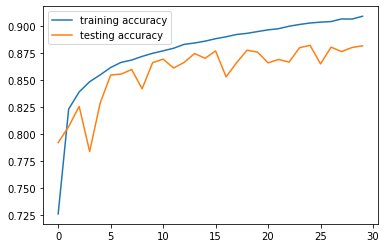

In [110]:
plt.plot(log.history['accuracy'],label = "training accuracy")
plt.plot(log.history['val_accuracy'], label = "testing accuracy")
plt.legend()
plt.show()

If we accept our model, we can evaluate it on the test set, using the `evaluate` function of our model:

In [111]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 539us/step - loss: 0.3523 - accuracy: 0.8749


[0.3523254990577698, 0.8748999834060669]

We can also take a look at some predictions:

In [112]:
X_new = X_test[:4]
y_predict = np.argmax(model.predict(X_new), axis=-1)
y_predict = [class_names[y] for y in y_predict]

Predictions are: ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']


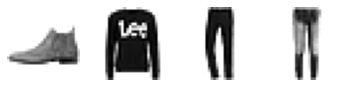

In [113]:
plt.subplot(1, 4, 1)
plt.imshow(X_test[0],cmap="binary")
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(X_test[1],cmap="binary")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(X_test[2],cmap="binary")
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(X_test[3],cmap="binary")
plt.axis('off')
print("Predictions are: " + str(y_predict))

Can you do better? Try tweaking the learning rate, the number of layers, and the neurons per layer to see if your validation loss improves. Once you have decided on your final model, evaluate it on the test set and note down your loss there.